<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [1]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos')

Estou rodando no Colab (S/N)?
S
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [2]:
#bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import matplotlib.gridspec as gridspec

#pré processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#modelos recorrentes Keras
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

#métricas de avaliação dos modelos.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

### Importação dos dados

In [3]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Separação de duas aeronaves para o teste final

In [4]:
np.random.seed(123)
np.random.randint(0,2,10)
test = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", test)

data_health  = data_health[data_health.COD_AENV != test[0]][data_health.COD_AENV != test[1]]

data_feat = data_feat[data_feat.COD_AENV != test[0]][data_feat.COD_AENV != test[1]]

print("Aviões usados para validação k-fold: ", np.unique(data_health.COD_AENV))


Aviões usados para teste:  [9834 9747]
Aviões usados para validação k-fold:  [1011 9486 9526 9636 9664 9678 9770 9793]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Calculo da mediana do desgaste e do valor da caracteristica por dia

União dos dois datasets

In [5]:
#calculando a mediana dos dados
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()

#Unificando os datasets 
data_health['id']=data_health.index
data_health.head()
data = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,COD_FALH,COD_AENV,COD_EVNT,COD_CARAC_NOM,VLR_CARAC,DT_PROC,VLR_DESG,id
3471,23,1011,116846,72.0,0.809445,2010-01-11,56.136860,6702
10389,35,1011,116846,63.0,0.000000,2010-01-11,4.396998,20114
6929,24,1011,116846,72.0,0.418330,2010-01-11,56.621538,13408
9906,24,9793,116311,72.0,0.000000,2010-01-11,60.415650,19291
6447,23,9793,116311,72.0,0.539028,2010-01-11,66.982252,12585


### Vizualização das séries

In [6]:
#visualizando todas as falhas de todas as aeronaves
px.line(data, x='DT_PROC', y='VLR_DESG', color='COD_AENV', line_dash='COD_FALH')


In [7]:
#visualizando de todas as características por aeronave e cod_falha
px.line(data, x='DT_PROC', y='VLR_CARAC', color='COD_AENV', line_dash='COD_FALH')

##Detecção de quebras

###Funções implementadas

In [8]:
#aplica filtro de média móvel
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') / w
  
  return desgaste_filt

#retorna os índices em que ocorrem as quebras
def quebra_filt(desgaste,dist):
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      

  quebras = np.array(quebras)

  return quebras

#verifica se os trechos atendem os requisitos de dias necessários
def desg_uti(desgaste,quebras,look_back):

  des_uti = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if i in quebras:
      if len(desgaste[a:i])>=n_pontos:
        des_uti = des_uti + desgaste[a:i+1].tolist()
      else:
        des_uti = des_uti + len(desgaste[a:i+1])*[-2]
        #print(a)
      a = i+1
  if len(desgaste[a:])>=n_pontos:
    des_uti = des_uti + desgaste[a:].tolist()
  else:
    des_uti = des_uti + len(desgaste[a:])*[-2]

  return des_uti  

#plota as séries e suas quebras
def func_plot (desgaste,quebras,aeronave,des_uti,lim):
  plt.figure(figsize=(15, 2),dpi=300)
  #plt.plot(carac,'xr',label='Carac')
  plt.plot(desgaste,'ok',label='Desgaste real', markersize=2)
  plt.plot(des_uti, 'or',label='Desgaste utilizado', markersize=2)
  plt.legend()
  plt.title(aeronave)
  plt.grid()
  plt.ylim([lim[0],lim[1]])
  plt.vlines(quebras, 0, 100)

#função principal para identificação e visualização para todas as aeronaves.
def descont(data,cod_falha,look_back,dist,lim):
  for aeronave in np.unique(data.COD_AENV):
    aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
    desgaste = aero_data.VLR_DESG.values
    quebra = quebra_filt(desgaste,dist)
    des_uti = desg_uti(desgaste,quebra,look_back)
    func_plot(desgaste,quebra,aeronave,des_uti,lim)

### Visualização das quebras por falha

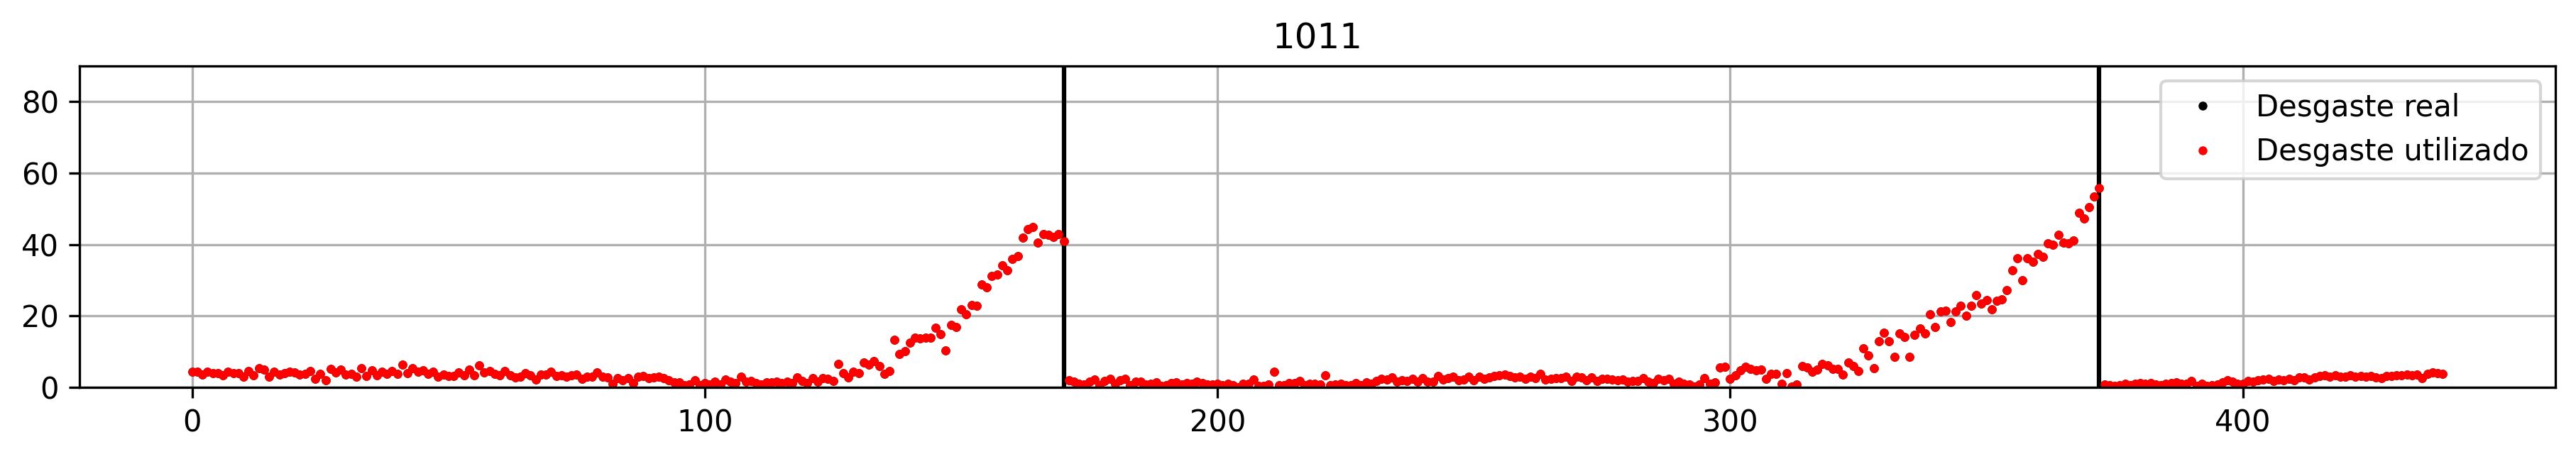

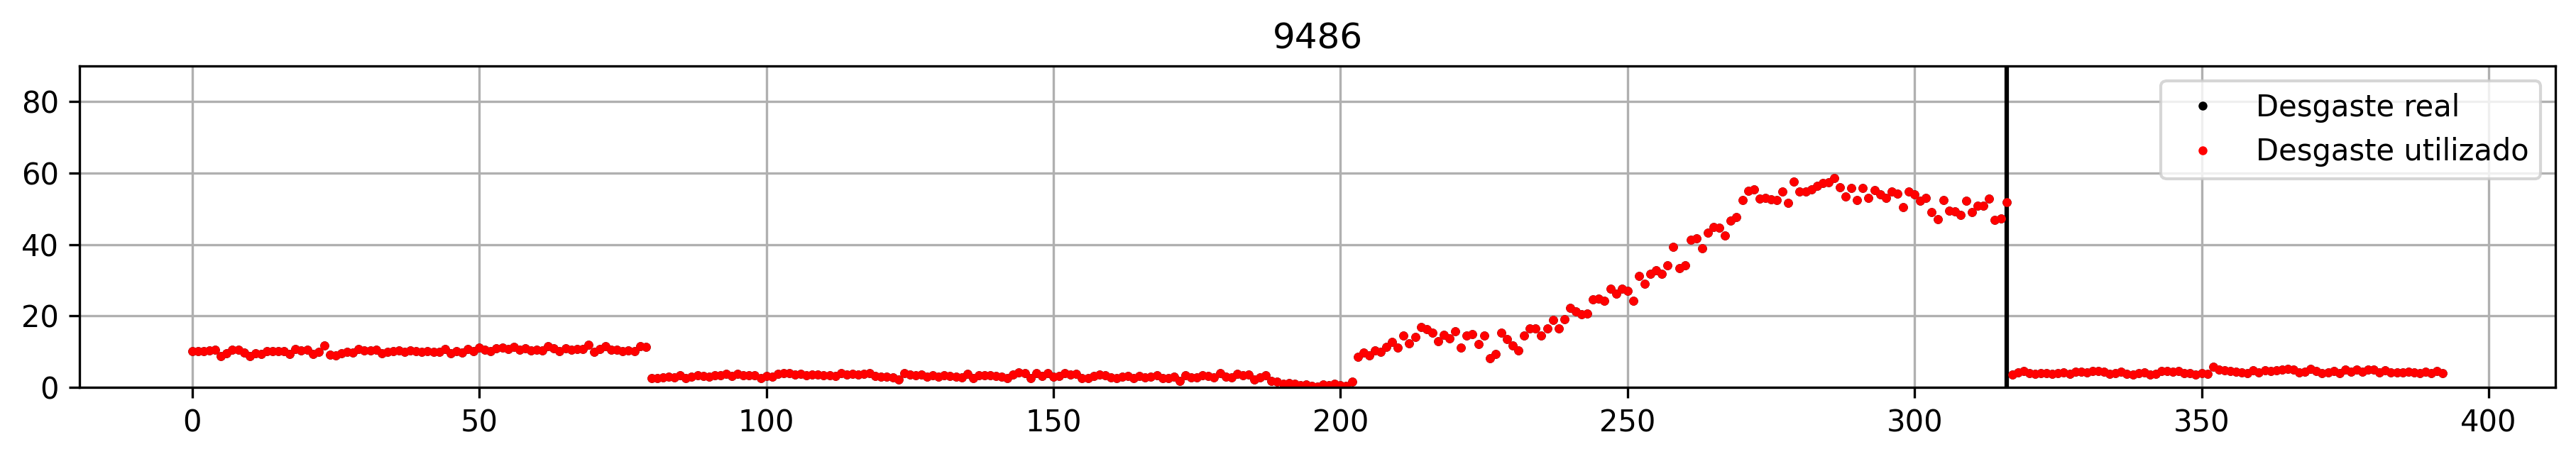

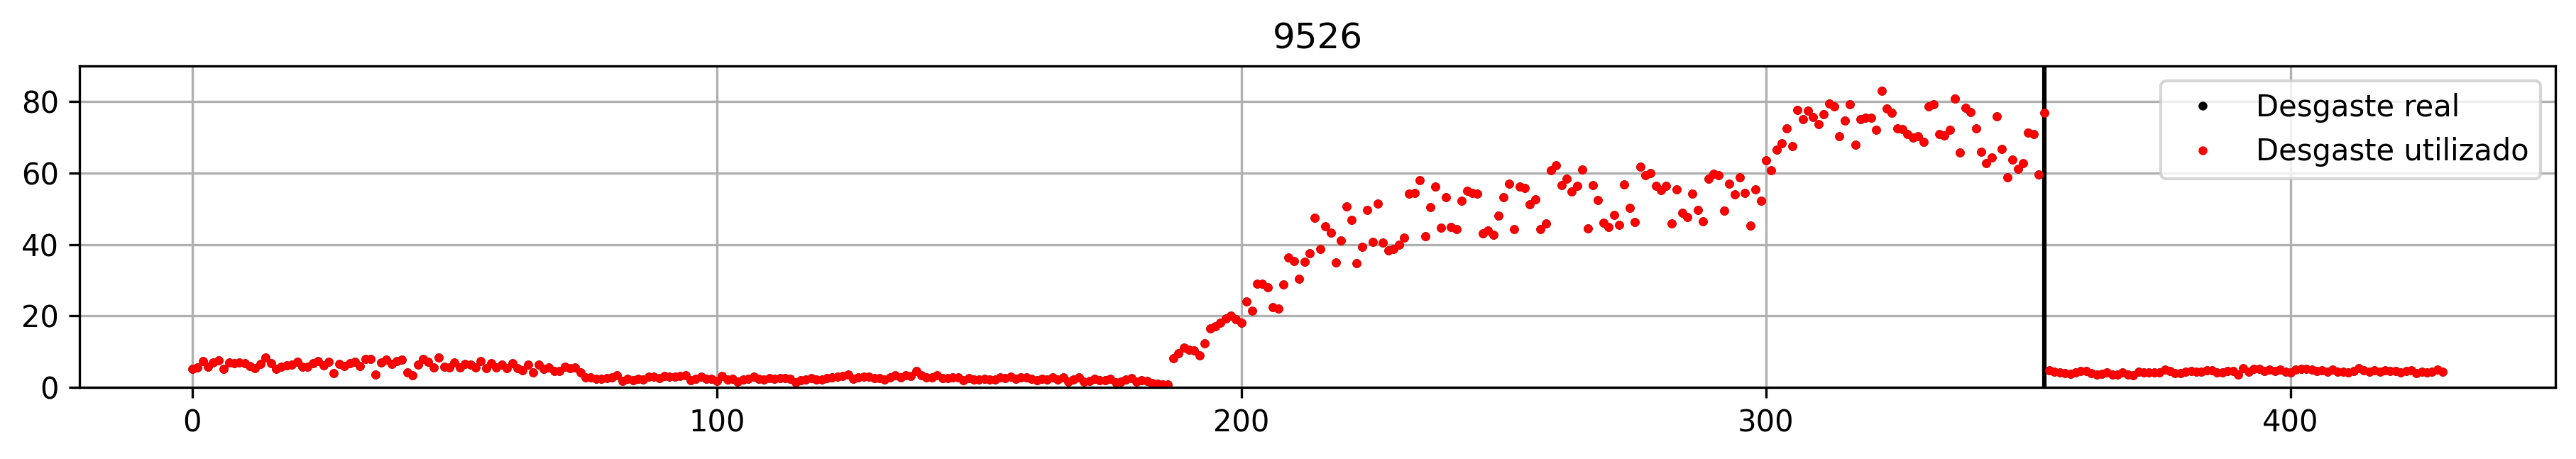

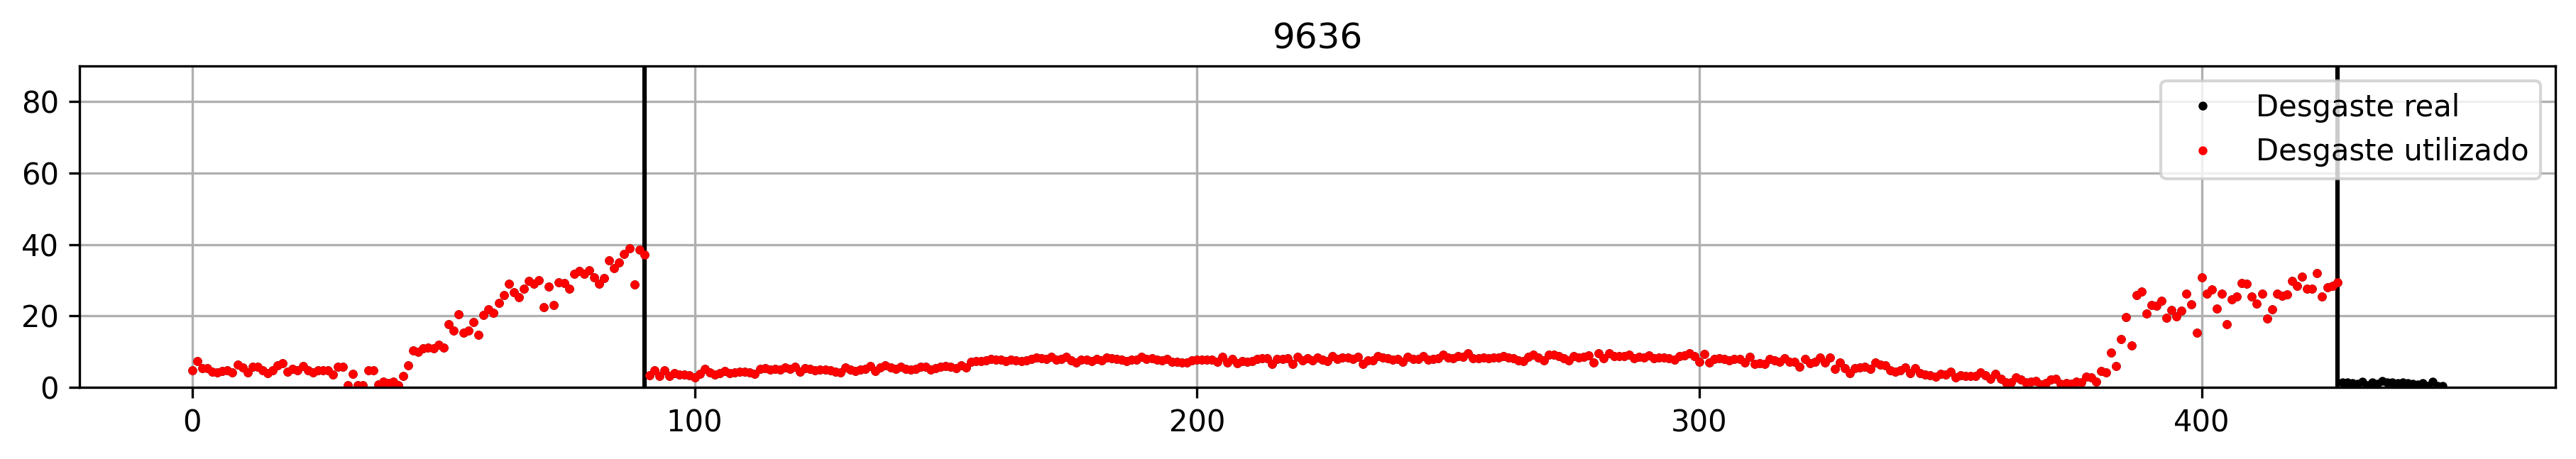

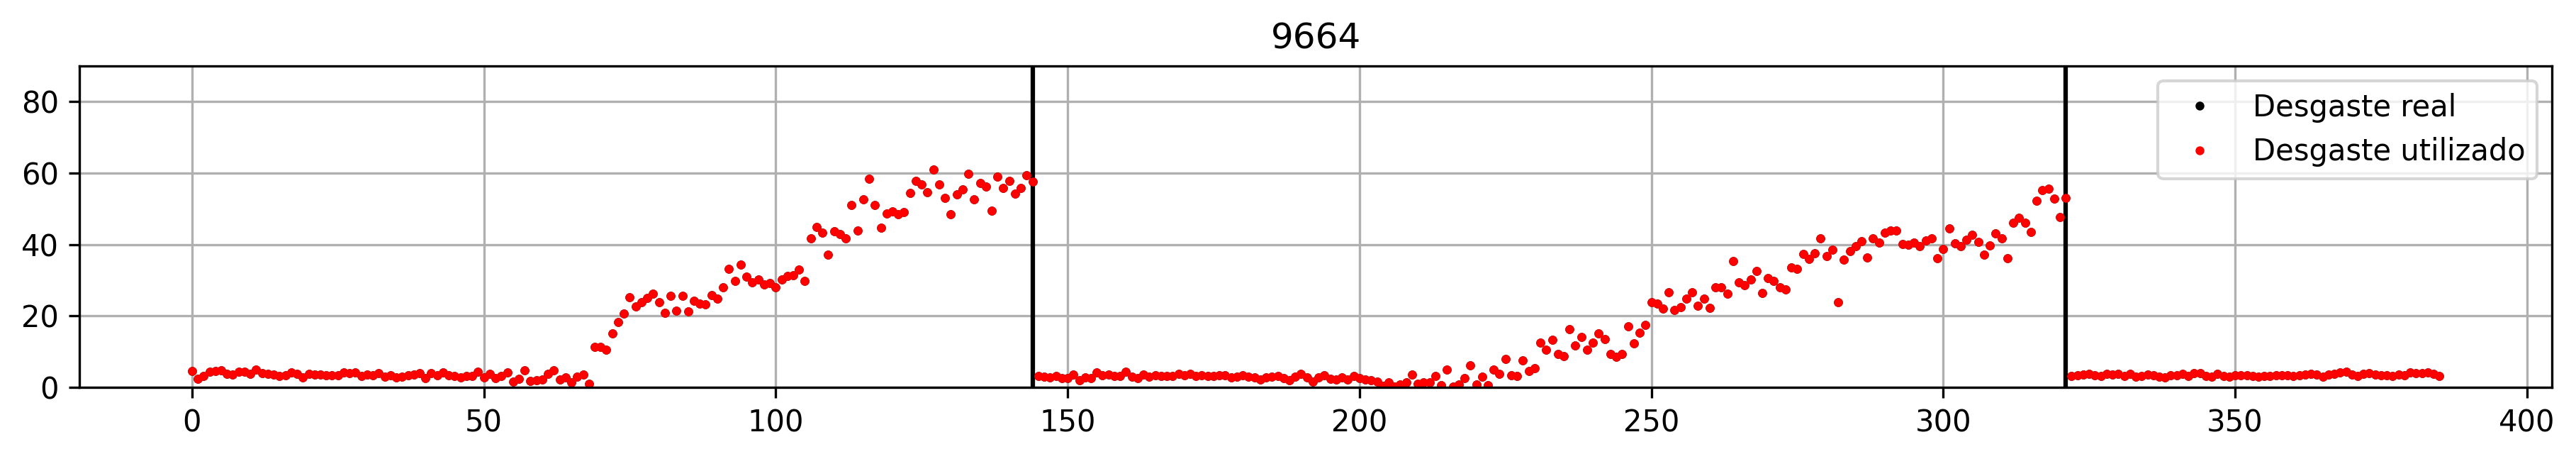

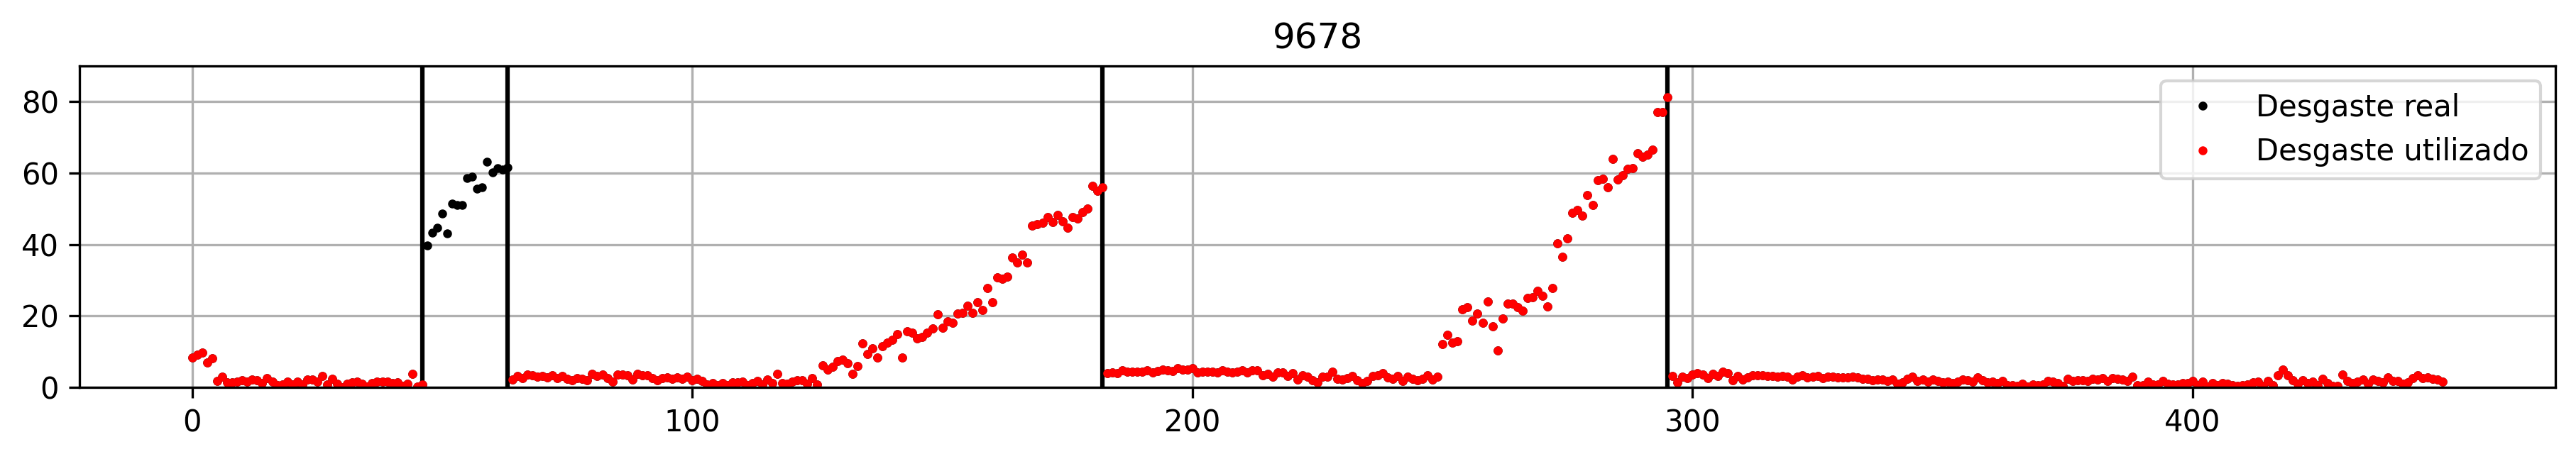

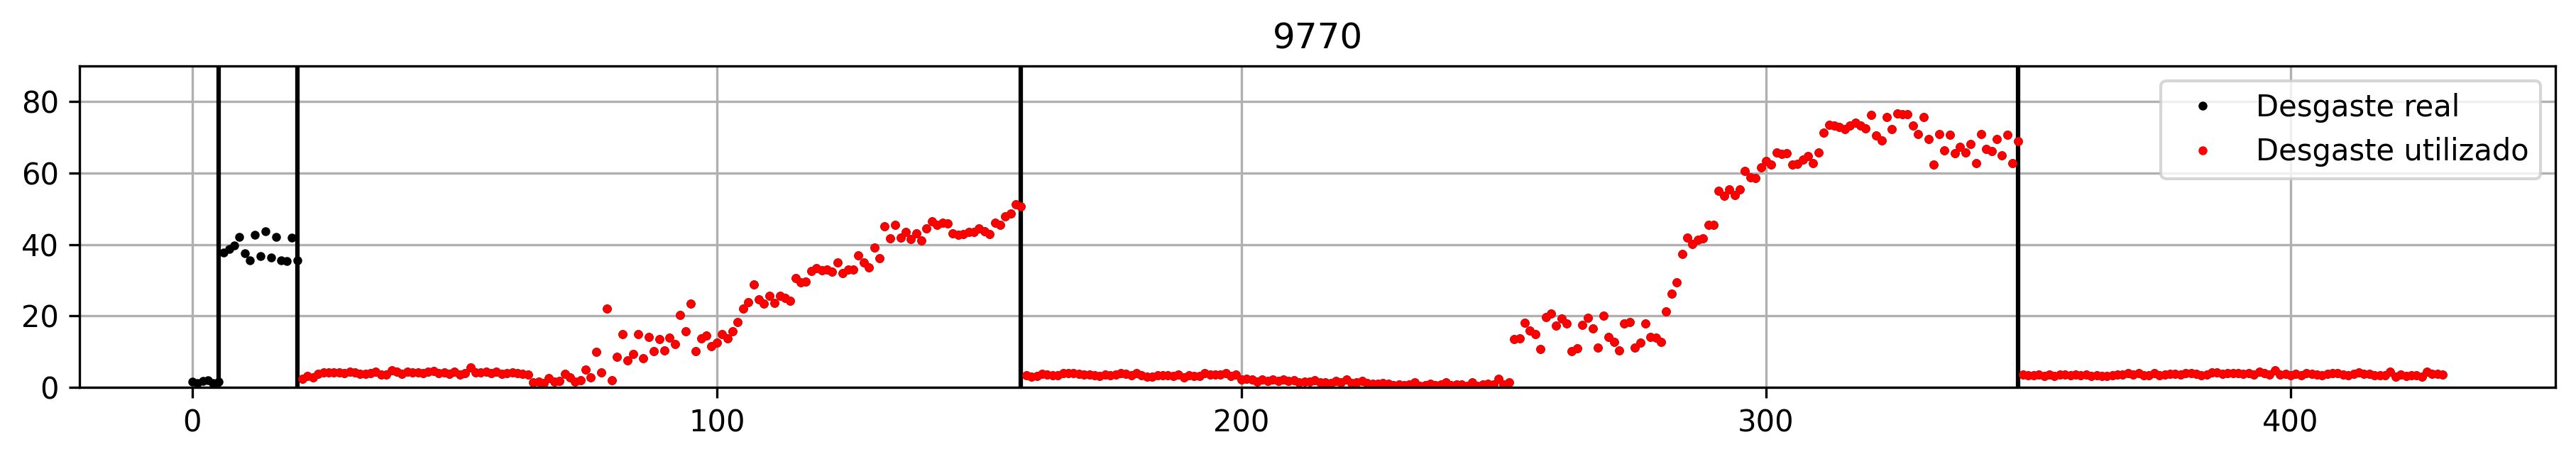

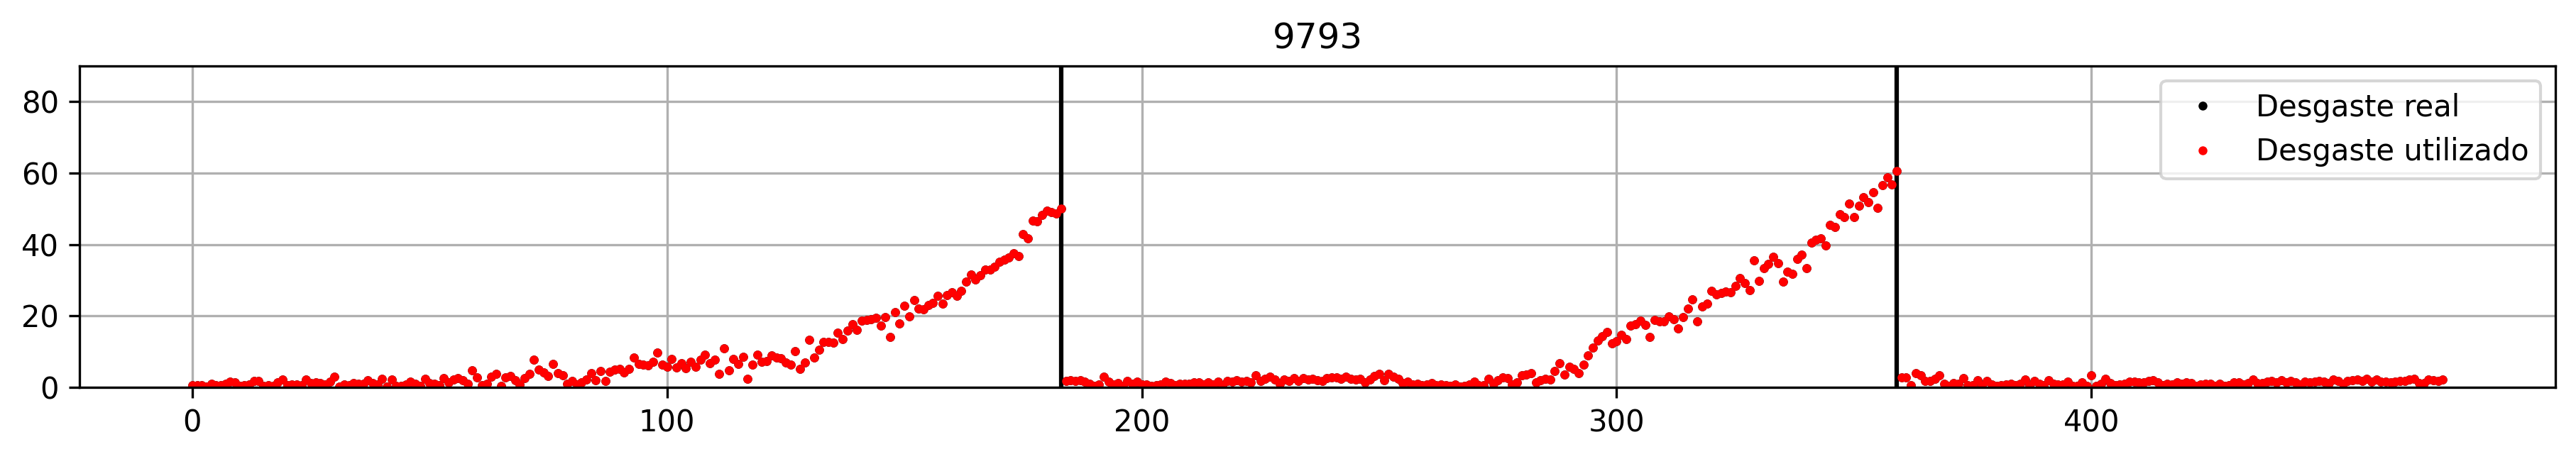

In [9]:

dist = 10   #distancia de pontos para considerar um quebra
cod_falha = 35 #1, 23, 24 e 35    #Definir qual falha deseja visualizar
look_back=20    #dias usados para predição
lim = [0,90]    #Limites do eixo y
aeronaves = np.unique(data.COD_AENV)
descont(data,cod_falha,look_back,dist,lim)

## Separação das amostras

In [10]:
#aplica filtro de média móvel
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') / w
  
  return desgaste_filt

#retorna os índices em que ocorrem as quebras
def discontinuity_filt(desgaste):
  dist = 10
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      
  quebras = np.array(quebras)

  return quebras

#Transforma o banco de dados em instâncias/amostras de acordo com o janela de tempo utilizada
def get_samples (data, cod_falha, look_back):
  samples=[]
  samples_day=[]
  n = look_back+10 #Tamanho (Dias) necessário da amostra

  for aircraft in np.unique(data.COD_AENV):
      air_data = data[(data.COD_AENV==aircraft)  & (data.COD_FALH==cod_falha)] #filtrando por aeronave e cod_falh
      degradation = air_data.VLR_DESG.values
      day = air_data.DT_PROC.values
      discontinuities = discontinuity_filt(degradation) #identificando as descontinuidades
      discontinuities=np.append(discontinuities, len(degradation)-1) #insere o fim do trecho
      init=0
      for i in range(0,len(discontinuities)): 
        interval_break=degradation[init:discontinuities[i]+1] #intervalo entre duas quebras
        interval_days = day[init:discontinuities[i]+1] #dias correspondentes ao intervalo 
        init=discontinuities[i]+1
        if len(interval_break)>=look_back+10: #verifica se os intervalos possuem a quantidade minima de valores
            for i in range(0,len(interval_break)-n+1): #separa os intervalos em amostras
              sample = interval_break[i:i+n].tolist() #uma amostra com n valores
              sample_day = interval_days[i:i+n].tolist() #dias correspondentes à amostra
              sample_day.append(aircraft)
              sample.append(aircraft)
              samples.append(sample)
              samples_day.append(sample_day)
      
  samples = np.array(samples)
  samples_day = np.array(samples_day)
  return  samples, samples_day 

#Separa as amostras em em X,Y e treino, teste
def split_train_test (samples, air_test, look_back, norm_method, reshape): 
  data_train = samples[samples[:, look_back+10] != air_test][:, 0:look_back+10] #dados de treino
  data_test = samples[samples[:, look_back+10] == air_test][:, 0:look_back+10] #dados de teste

  #seperação de x e y
  x_train = data_train[:,0:look_back]
  y_train = data_train[:,look_back+9]
  x_test = data_test[:,0:look_back]
  y_test = data_test[:,look_back+9]

  #normalização de x e y
  x_train, x_scaler = normalize_samples(x_train, norm_method)
  x_test = x_scaler.transform(x_test)
  y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)
  y_test = y_scaler.transform(y_test.reshape(-1, 1))

  #reshape para treinar os modelos recorrentes
  if reshape==True:
      x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
      y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
      x_test  = np.reshape(x_test , (x_test.shape[0], 1, x_test[0].shape[0]))
      y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  #retorna os scalers para reverter a normalização
  return x_train, y_train, x_test, y_test, y_scaler, x_scaler 

#Normalização das amostras
def normalize_samples(samples, norm_method):
  if norm_method=="MM(-1,1)":
    scaler = MinMaxScaler(feature_range=(-1, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="MM(0,1)":
    scaler = MinMaxScaler(feature_range=(0, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="Zscore":
    scaler = StandardScaler()
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  else:
    return samples

#Visualização desgaste esperado vs. desgaste predito
def plot_results(y_test, y_pred, air_test):
  rmse = mean_squared_error(y_test, y_pred, squared = False)
  plt.figure(dpi=100,figsize=(20,5))
  plt.plot(y_test,':ok')
  plt.plot(y_pred,'-xm')
  plt.title("Aeronave: "+ str(int(air_test))+' | RMSE='+str(round(rmse,3)))
  plt.xlabel("Dias")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  # plt.ylim([0,80])

### Visualização das amostras


Text(0, 0.5, 'Desgaste (%)')

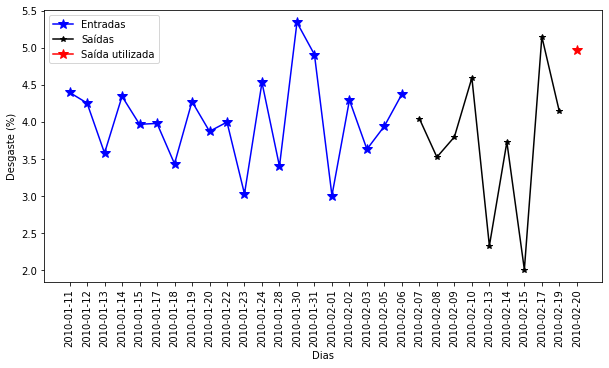

In [11]:
cod_falha = 35
look_back = 20

samples, samples_day = get_samples (data, cod_falha, look_back)

x=samples[:,0:look_back] #Entradas
y_used=samples[:,look_back+9] #Saída utilizada
y=samples[:,look_back:look_back+9] #Saídas não utilizadas

x_day=samples_day[:,0:look_back] #Dias das entradas
y_used_day=samples_day[:,look_back+9] #Dia da saída utilizada
y_day=samples_day[:,look_back:look_back+9] #Dias das saídas não utilizadas

#Visualizando uma amostra
plt.figure(figsize=(10,5))
plt.plot(x_day[0], x[0], "b-*", label="Entradas", markersize=10)
plt.xticks(rotation=90)
plt.plot(y_day[0], y[0], "k-*", label="Saídas")
plt.plot(y_used_day[0], y_used[0], "r-*", label="Saída utilizada", markersize=10)
plt.legend()
plt.xlabel("Dias")
plt.ylabel("Desgaste (%)")

In [12]:
#Visualizando os métodos de normalização
air_test=1011
norm_method="Zscore"
print("Método",  "     Min", "                 Máx", "                    Média", "            Desvio")
for norm_method in ["MM(-1,1)", "MM(0,1)", "Zscore"]:
  x_train, y_train, x_test, y_test, scaler, _ = split_train_test (samples, air_test, look_back, norm_method, reshape = False)
  print(norm_method,np.min(x_train[:,0]),np.max(x_train[:,0]),np.mean(x_train[:,0]),np.std(x_train[:,0]),'\n')
  


Método      Min                  Máx                     Média             Desvio
MM(-1,1) -0.9999999999999999 1.0000000000000002 -0.7472048319397064 0.3642033481852817 

MM(0,1) 0.0 1.0 0.12639758403014675 0.18210167409264086 

Zscore -0.6941044592805032 4.797333249805405 -6.620697704253845e-16 1.0000000000000002 



##GridSearch

### Funções implementadas

In [13]:
#Retorna todas as métricas calculadas
def metrics(y_true,y_pred):
  mse  = mean_squared_error(y_true, y_pred) 
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  max_e =  max_error(y_true, y_pred) 
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return([rmse, mse, max_e, mae, r2])

#Seleciona o modelo
def shallow_model (name, n_recurr, n_dense, dropout, l2, look_back, forget_gate=True):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(n_recurr, input_shape=(1, look_back)))
  elif name=="GRU":
      model.add(GRU(n_recurr, input_shape=(1, look_back)))
  elif name == "RNN":
      model.add(RNN(n_recurr, input_shape=(1, look_back)))
  else:
      print("Model not found")

  if n_dense>0:
    if l2==True:
      model.add(Dense(n_dense, kernel_regularizer='l2'))
    else:
      model.add(Dense(n_dense))

  model.add(Dropout(dropout))

  if l2==True:
    model.add(Dense(1, kernel_regularizer='l2'))
  else:
    model.add(Dense(1))
  
  return model

In [14]:
#Seleciona o modelo
def deep_model (name, n_recurr, n_dense, dropout, l2, look_back, forget_gate=True):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(LSTM(n_recurr[1], return_sequences = True))
      model.add(LSTM(n_recurr[2]))
  elif name=="GRU":
      model.add(GRU(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(GRU(n_recurr[1], return_sequences = True))
      model.add(GRU(n_recurr[2]))
  elif name == "RNN":
      model.add(RNN(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(RNN(n_recurr[1], return_sequences = True))
      model.add(RNN(n_recurr[2]))
  else:
      print("Model not found")

  if n_dense>0:
    if l2==True:
      model.add(Dense(n_dense, kernel_regularizer='l2'))
    else:
      model.add(Dense(n_dense))

  model.add(Dropout(dropout))

  if l2==True:
    model.add(Dense(1, kernel_regularizer='l2'))
  else:
    model.add(Dense(1))
  
  return model

In [45]:
def grid_search_recurrent (data, falh, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach):

  data_results = pd.DataFrame([],columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',
                                          "Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])

  for look_back in windows98:
    amostras, _ = get_samples (data, cod_falha, look_back)
    results = []
    for norm_method in norm_methods:
      for aero_test in np.unique(data.COD_AENV):
        x_train, y_train, x_test, y_test, scaler, _ = split_train_test (amostras, aero_test, look_back, norm_method, reshape = True)
        for name in model_name:
          for n_r in n_recurr:
            for n_d in n_dense:
              for drop in dropout:
                for l in l2:
                  if approach=="shallow":
                    model = shallow_model(name, n_r, n_d, drop, l, look_back)
                  elif approach=="deep":
                    model = deep_model(name, n_r, n_d, drop, l, look_back)
                  else:
                    print("Approach not found!")
                  
                  early_stopping = EarlyStopping(patience=5)
                  model.compile(loss='mean_squared_error', optimizer='adam')
                  model.fit(x_train, y_train, epochs=400, batch_size=170, validation_split=0.2, callbacks=[early_stopping], verbose=0)
                  
                  #revertendo a normalização
                  y_test_rev = scaler.inverse_transform(y_test[:,0].reshape(-1,1))
                  y_pred_rev = scaler.inverse_transform(model.predict(x_test, verbose=0)[:,0].reshape(-1,1))
                  
                  #adiciona os resultados em uma lista
                  result = metrics(y_test_rev,y_pred_rev)
                  result.append(name)
                  result.append(falh)
                  result.append(look_back)
                  result.append(int(aero_test))
                  result.append(norm_method)
                  result.append(model.count_params())
                  parameters = {'Recurrent': n_r, 'Dense': n_d, 'Dropout': drop, 'L2': l}
                  result.append(parameters)
                  #salvando os resultados  
                  results.append(result)
                  # print(['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])
                  # print(result)
                  # print()
    data_results = pd.concat([data_results, pd.DataFrame(results,
                    columns= ['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])])
    filename = 'resultados/recurrent_'+approach+'_lk'+str(look_back)+'_f'+str(falh)+'.csv'
    print(filename)
    data_results.to_csv(filename) #exporta os resultados em CSV para cada tamanho de janela

### Treinamento e predição do modelo shallow

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [10, 20, 30]#[5,10,15,20,25,30]
falh = 35
model_name = ['RNN', 'GRU', 'LSTM']
n_recurr = [32, 256]#[14,16,21,32,64,128,256]
n_dense = [0,56]
dropout = [0, 0.5]#[0, 0.5, 0.7]
l2 = [True, False]
approach="shallow"

grid_search_recurrent (data, falh, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach)


In [26]:
#Selecionando os melhores modelos para cada falha
data_results=pd.read_csv('resultados/resul_lk30_f35.csv', index_col=0)
data_results_new = data_results.groupby(['Modelo','Recorrente', 'Denso', 'Dropout', 'L2', "JANELA"]).mean().reset_index()
data_results_new.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)

,Modelo,Recorrente,Denso,Dropout,L2,JANELA,MSE,RMSE,MaxE,MAE,R2,AENV,N_Parâmetros,MOD_FALH
0,GRU,256,56,0.0,False,20,27.442177,5.087239,21.490151,3.414802,0.895524,8570.5,227953.0,35.0
1,LSTM,256,56,0.0,False,20,28.922582,5.230769,21.351857,3.683422,0.889759,8570.5,298097.0,35.0
2,RNN,32,0,0.0,True,20,27.507090,5.090758,22.024888,3.573747,0.895266,8570.5,1729.0,35.0


###Treinamento e predição do modelo deep

In [40]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [10, 20, 30]#[5,10,15,20,25,30]
falh = 35
model_name = ['RNN', 'GRU', 'LSTM']
n_recurr = [[14, 21, 14],  [21, 28, 21]]
n_dense = [0,56]
dropout = [0, 0.5]#[0, 0.5, 0.7]
l2 = [True, False]
approach="deep"

grid_search_recurrent (data, falh, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach)

12/12 [==============================] - 0s 3ms/step
['RMSE', 'MSE', 'MaxE', 'MAE', 'R2', 'Modelo', 'MOD_FALH', 'Janela', 'AENV', 'Normalização', 'N_Parâmetros', 'Parâmetros']
[3.608371646963616, 13.02034594261092, 15.60687950220003, 2.66234167132707, 0.9016995898699209, 'RNN', 35, 10, 1011, 'MM(-1,1)', 1625, {'Recurrent': [14, 21, 14], 'Dense': 0, 'Dropout': 0, 'L2': True}]

12/12 [==============================] - 0s 2ms/step
['RMSE', 'MSE', 'MaxE', 'MAE', 'R2', 'Modelo', 'MOD_FALH', 'Janela', 'AENV', 'Normalização', 'N_Parâmetros', 'Parâmetros']
[3.7446159023008057, 14.022148255764078, 16.6265193939209, 2.160672772812672, 0.894136228751386, 'RNN', 35, 10, 1011, 'MM(-1,1)', 1625, {'Recurrent': [14, 21, 14], 'Dense': 0, 'Dropout': 0, 'L2': False}]

12/12 [==============================] - 0s 2ms/step
['RMSE', 'MSE', 'MaxE', 'MAE', 'R2', 'Modelo', 'MOD_FALH', 'Janela', 'AENV', 'Normalização', 'N_Parâmetros', 'Parâmetros']
[4.570976123876509, 20.893822725049116, 17.678740605586754, 3.95

KeyboardInterrupt: ignored

In [ ]:
#Selecionando os melhores modelos para cada falha
data_results=pd.read_csv('resultados/deep_resul_lk20_f35.csv', index_col=0)
data_results_new = data_results.groupby(['Modelo','Recorrente', 'Denso', 'Dropout', 'L2', "JANELA"]).mean().reset_index()
data_results_new.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)